## Visualization
Rosenbaum's test has a known, exact null distribution, which is exactly distribution free, meaning that the test works for any underlying distributions F and G which are tested on being equal. 
It constructs an optimal bi-partite matching of all observations, meaning that it pairs each data point to exactly one other, minimizing the within-pair distances.
If F and G are similar or equal, the matching will result in a high number of cross-matches (pairs with one observation from each of the groups). If they are different, the minimal distance pairs will mostly be from the same groups.    
This notebooks visualizes the Rosenbaum test with two distributions. 

#### Experiment with the distributions to see the effects on the matching!

In [1]:
%load_ext autoreload
%autoreload 2

In [43]:
import numpy as np 
from graph_tool.all import Graph, graph_draw
import pandas as pd
import anndata as ad
import sys
sys.path.append("..")
from rosenbaum import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import itertools
np.random.seed(42)

In [44]:
metric = "sqeuclidean"

In [45]:
n_samples = 15
samples_A = [np.random.normal((0,0), (1,1), 2) for _ in range(n_samples)]
samples_B = [np.random.normal((2,1), (1,1), 2) for _ in range(n_samples)]


groups = ["A"] * n_samples + ["B"] * n_samples  
samples = np.array(samples_A + samples_B) 
adata = ad.AnnData(samples)
adata.obs["Group"] = groups

In [46]:
test = "A"
reference = "B"
metric="sqeuclidean"
distances = calculate_distances_nx(adata.X, metric)
G = construct_graph_from_distances_nx(distances)
matching = match_nx(G)
p_val, z, support = rosenbaum(adata, group_by="Group", test_group=test, reference=reference, nx=True)

using CPU to calculate distance matrix.
creating distance graph.
30
XMatch_group
test         15
reference    15
Name: count, dtype: int64
matching samples.
using CPU to calculate distance matrix.
creating distance graph.
counting cross matches.


/data/bionets/je30bery/rosenbaum_test/notebooks/../rosenbaum/rosenbaum.py:149: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["XMatch_group"] = np.where(adata.obs[group_by].isin(test_group), "test", "reference")


In [47]:
sc.pp.neighbors(adata, n_neighbors=5, metric=metric)

In [48]:
G_knn = nx.from_scipy_sparse_array(adata.obsp["distances"])

In [49]:
G_matching = nx.from_edgelist(matching)

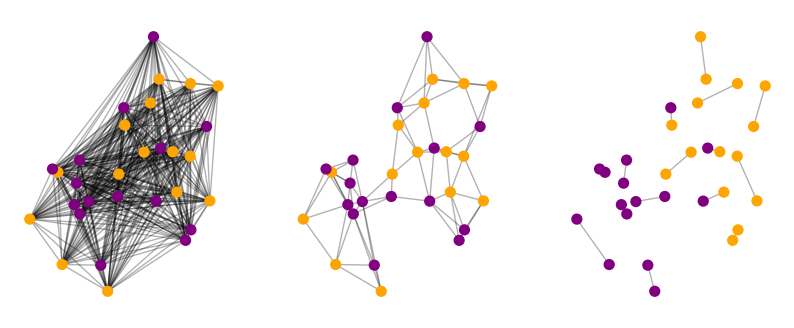

In [59]:
f, axs = plt.subplots(1, 3, figsize=(10, 4))
used_elements = list(chain.from_iterable(matching))
pos = {i: adata.X[i] for i in used_elements}
n_colors = adata.obs["Group"].replace({"A": "purple", "B": "orange"}).values[used_elements]
weights = [G[u][v].get('weight', 1) for u, v in G.edges()]  # Default weight is 1 if not provided
weights_norm = (weights - np.min(weights)) / (np.max(weights) - np.min(weights))  # Normalize to [0, 1]

nx.draw(G, pos=pos, node_color=n_colors, edge_color=(0,0,0,0.3), node_size=50, ax=axs[0])
nx.draw(G_knn, pos=pos, node_color=n_colors, edge_color=(0,0,0,0.3), node_size=50, ax=axs[1])
nx.draw(G_matching, pos=pos, node_color=n_colors, edge_color=(0,0,0,0.3), node_size=50, ax=axs[2])

In [60]:
p_val, z, support = rosenbaum(adata, group_by="Group", test_group="A", reference="B", nx=True)

30
XMatch_group
test         15
reference    15
Name: count, dtype: int64
matching samples.
using CPU to calculate distance matrix.
creating distance graph.
counting cross matches.


/data/bionets/je30bery/rosenbaum_test/notebooks/../rosenbaum/rosenbaum.py:149: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["XMatch_group"] = np.where(adata.obs[group_by].isin(test_group), "test", "reference")


In [61]:
p_val

0.022346411933352156

In [12]:
used_elements = list(chain.from_iterable(matching))

pos = {i: adata.X[i] for i in used_elements}
G = nx.Graph()

e_colors = list()
for u, v in matching:
    if adata.obs["Group"].iloc[u] == adata.obs["Group"].iloc[v]:
        e_colors.append((0.9, 0.9, 0.9))
    else:
        e_colors.append((0, 0, 0))

G.add_edges_from(matching)
n_colors = adata.obs["Group"].replace({"A": "purple", "B": "orange", "C": "green", "D": "pink", "E": "blue", "F": "yellow", "G": "lightblue"}).values[used_elements]
nx.draw(G, pos=pos, node_color=n_colors, edge_color=e_colors, node_size=10, ax=ax)
ax.set_title(f"P={p_val:.5f}, z={z:.3f}")
#ax.axis("off")

NameError: name 'ax' is not defined

In [ ]:
legend_elements = {
    "A": Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=8, label=r'$~\mathcal{N}((0,0), (1,1))$'),
    "B": Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=8, label=r'$~\mathcal{N}((0,0), (1,1))$'),
    "C": Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label=r'$~\mathcal{N}((1,0), (1,1))$'),
    "D": Line2D([0], [0], marker='o', color='w', markerfacecolor='pink', markersize=8, label=r'$~\mathcal{N}((2,0), (1,1))$'),
    "E": Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label=r'$~\mathcal{N}((0,0), (2,2))$'),
    "F": Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=8, label=r'$~\mathcal{N}(((0,0), (3,3))$'),
    "G": Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=8, label=r'$~\mathcal{N}((1,1), (2,2))$'),
}
edge_legend_elements = [
    Line2D([0], [0], color=(0.9, 0.9, 0.9), lw=2, label=r'Iso-match'),
    Line2D([0], [0], color=(0, 0, 0), lw=2, label=r'Cross-match')
]

In [ ]:
f, axs = plt.subplots(2, 3, figsize=(12, 8))
for i, reference in enumerate(["B", "C", "D", "E", "F", "G"]):

    x = i // 3
    y = i % 3
    draw_matching(adata_subset, matching, p_val, z, support, axs[x, y])
    axs[x, y].legend(handles=[legend_elements["A"], legend_elements[reference]] + edge_legend_elements, loc='lower center', bbox_to_anchor=(0.5,-0.5), ncol=2)

plt.tight_layout()
plt.show()